# **TP1 - Vision Transformers**

# **Florentino Arias (a1719)**

## **Especialización en Inteligencia Artificial FIUBA 2b2025 - Visión por Computadora III**

### **Objetivo del Trabajo Práctico:**
* Analizar el impacto de modificar los parámetros del Vision Transformer, en particular:
  * El tamaño de los parches de imagen (patch size).
  * La cantidad de dimensiones del embedding de los parches (embedding dimension).
* Implementar una codificación posicional aprendida utilizando PyTorch, comparándola con la codificación sinusoidal tradicional.
* Visualizar y comparar gráficamente ambas codificaciones posicionales.

### **Modificaciones realizadas:**
* Se modificó el tamaño de los parches a 32 píxeles (antes 64).
* Se aumentó la dimensión de los embeddings a 32 (antes 8).

### **Implementaciones:**
* PositionalEncoding: codificación posicional sinusoidal (base teórica de Transformers).
*PositionalEncodingLearned: codificación posicional aprendida mediante parámetros entrenables.
* Comparaciones visuales entre codificaciones para evaluar diferencias.

### **Conclusiones:**
Se discuten las ventajas y desventajas de modificar el tamaño de los parches y la dimensión de los embeddings en relación al costo computacional, capacidad de representación, y eficiencia del modelo.

* Todo el trabajo fue desarrollado usando PyTorch.
* Las imágenes utilizadas fueron preprocesadas a un tamaño de 900x900 píxeles.
* Se utilizó como imagen de entrada un mapache (raccoon.jpg, proporcionado por la cátedra).



In [1]:
import torch
from torch import nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import math

# Configuración y preprocesamiento
class ConfigPreprocess:
    def __init__(self, img_path: str, img_size: int, patch_size: int):
        self.device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
        print(f'Dispositivo utilizado: {self.device}')
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: torch.Tensor) -> torch.Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches

# Embedding de parches
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

# Codificación posicional sinusoidal
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.register_buffer('pos_embedding', self.create_positional_encoding(num_patches, embed_dim))

    def create_positional_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        pos_encoding = torch.zeros(num_patches, embed_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        return pos_encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.pos_embedding

# Codificación posicional aprendida
class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding

# Visualización
class Visualization:
    @staticmethod
    def visualize_patches(patches: torch.Tensor):
        num_patches = patches.shape[1]
        num_cols = int(num_patches ** 0.5)
        num_rows = (num_patches + num_cols - 1) // num_cols
        _, axs = plt.subplots(num_rows, num_cols, figsize=(4, 4))
        for i in range(num_rows):
            for j in range(num_cols):
                idx = i * num_cols + j
                if idx < num_patches:
                    patch = patches[:, idx]
                    num_channels = patch.shape[0]
                    if num_channels == 1:
                        axs[i, j].imshow(patch.squeeze().detach().cpu().numpy(), cmap='gray')
                    elif num_channels == 3:
                        axs[i, j].imshow(patch.permute(1, 2, 0).detach().cpu().numpy())
                    axs[i, j].axis('off')
                else:
                    axs[i, j].axis('off')
        plt.tight_layout(pad=0.15)
        plt.show()

    @staticmethod
    def visualize_positional_encoding(pos_embeddings: torch.Tensor):
        plt.figure(figsize=(14, 4))
        plt.title('Codificaciones Posicionales para los Parches', fontsize=16, weight='bold')
        for i in range(pos_embeddings.shape[2]):
            plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dim {i + 1}')
        plt.xlabel('Índice del Parche', fontsize=14)
        plt.ylabel('Valor de la Codificación Posicional', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

    @staticmethod
    def visualize_single_patch_encoding(pos_embeddings: torch.Tensor, patch_idx: int):
        patch_encoding = pos_embeddings[0, patch_idx, :].detach().cpu().numpy()
        plt.figure(figsize=(14, 4))
        plt.plot(patch_encoding, marker='o', label=f'Parche {patch_idx + 1}')
        plt.title(f'Encoding Posicional para el Parche {patch_idx + 1}', fontsize=16, weight='bold')
        plt.xlabel('Dimensión del Embedding', fontsize=14)
        plt.ylabel('Valor del Encoding', fontsize=14)
        plt.grid()
        plt.legend()
        plt.show()


In [4]:

from google.colab import drive
drive.mount('/content/drive')

# Parámetros modificados
img_path = "/content/drive/MyDrive/Colab Notebooks/VPCIII/raccoon.jpg"
img_size = 900
patch_size = 32  # antes 64
embed_dim = 32   # antes 8
patch_idx = 0  # parche que queremos graficar


Mounted at /content/drive


Dispositivo utilizado: cuda


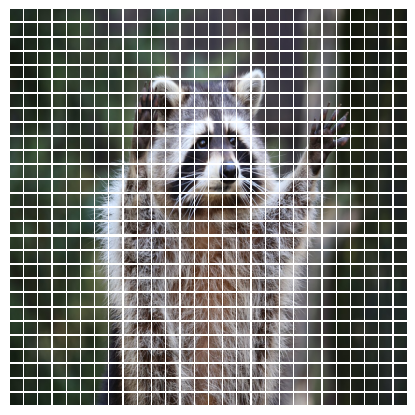

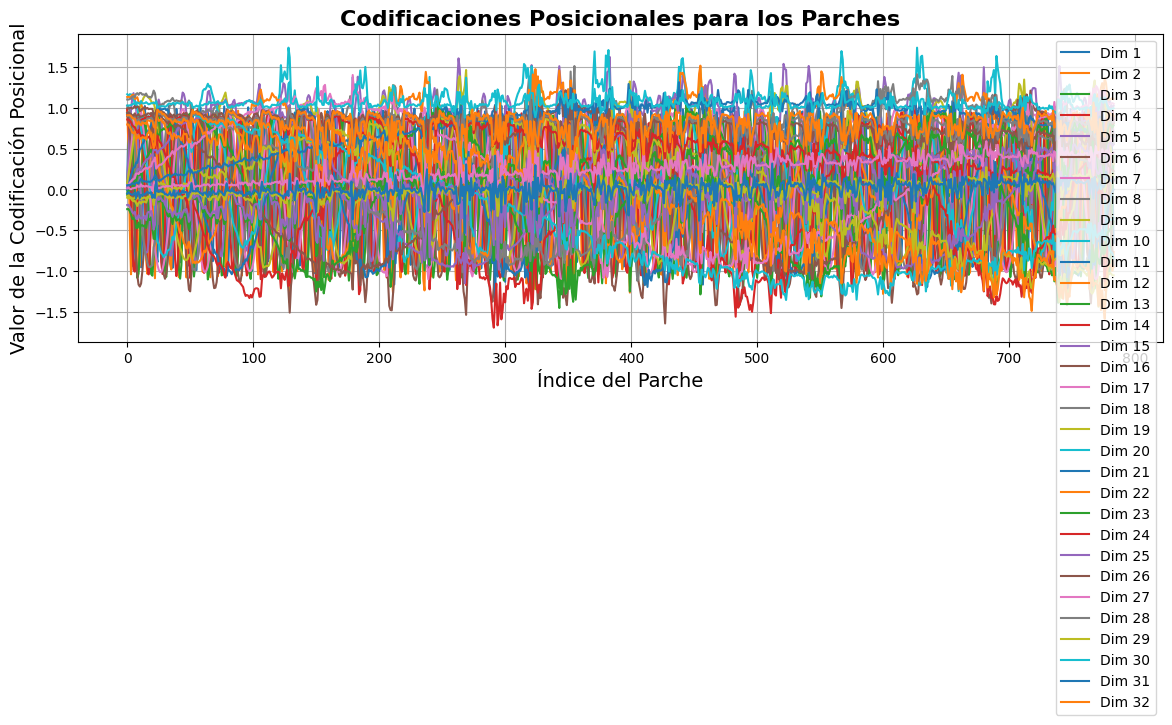

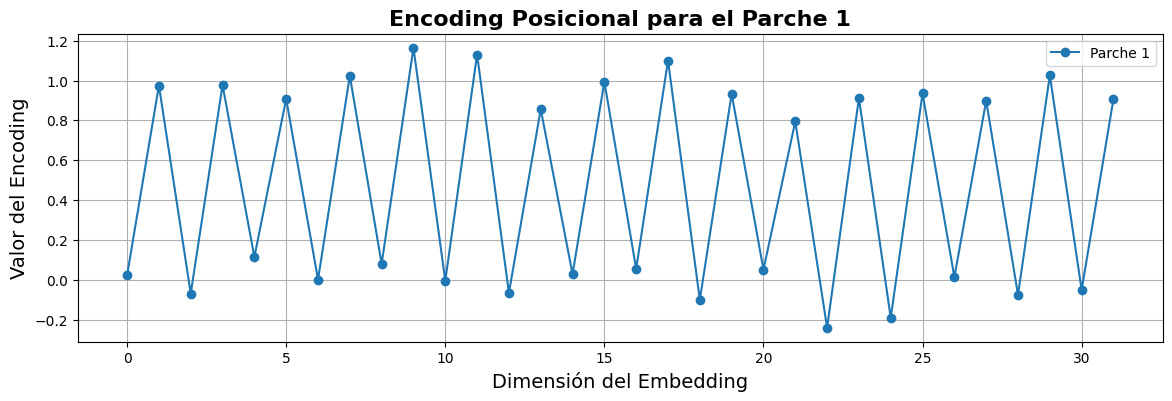

In [5]:

# Preprocesamiento
config = ConfigPreprocess(img_path, img_size, patch_size)

# Extracción de parches
patches = config.extract_patches(config.test_img.squeeze(0))
Visualization.visualize_patches(patches)

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional sinusoidal
num_patches = (img_size // patch_size) ** 2
positional_encoding = PositionalEncoding(num_patches, embed_dim).to(config.device)
pos_embeddings = positional_encoding(patches)
Visualization.visualize_positional_encoding(pos_embeddings)
Visualization.visualize_single_patch_encoding(pos_embeddings, patch_idx)


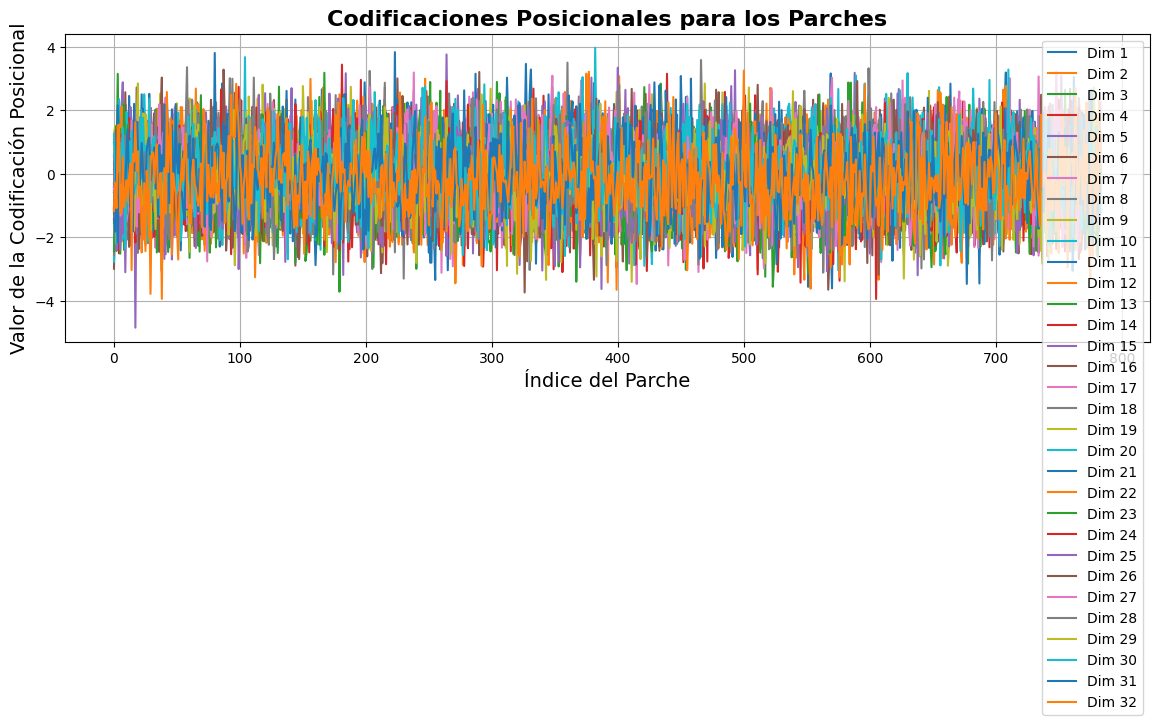

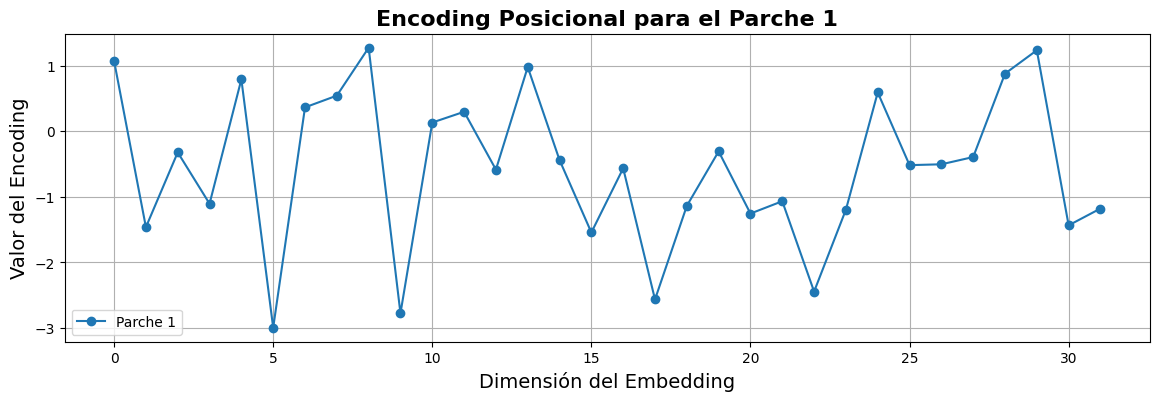

In [6]:

# Codificación posicional aprendida
positional_encoding_learned = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
pos_embeddings_learned = positional_encoding_learned(patches)

# Visualizar
Visualization.visualize_positional_encoding(pos_embeddings_learned)
Visualization.visualize_single_patch_encoding(pos_embeddings_learned, patch_idx)


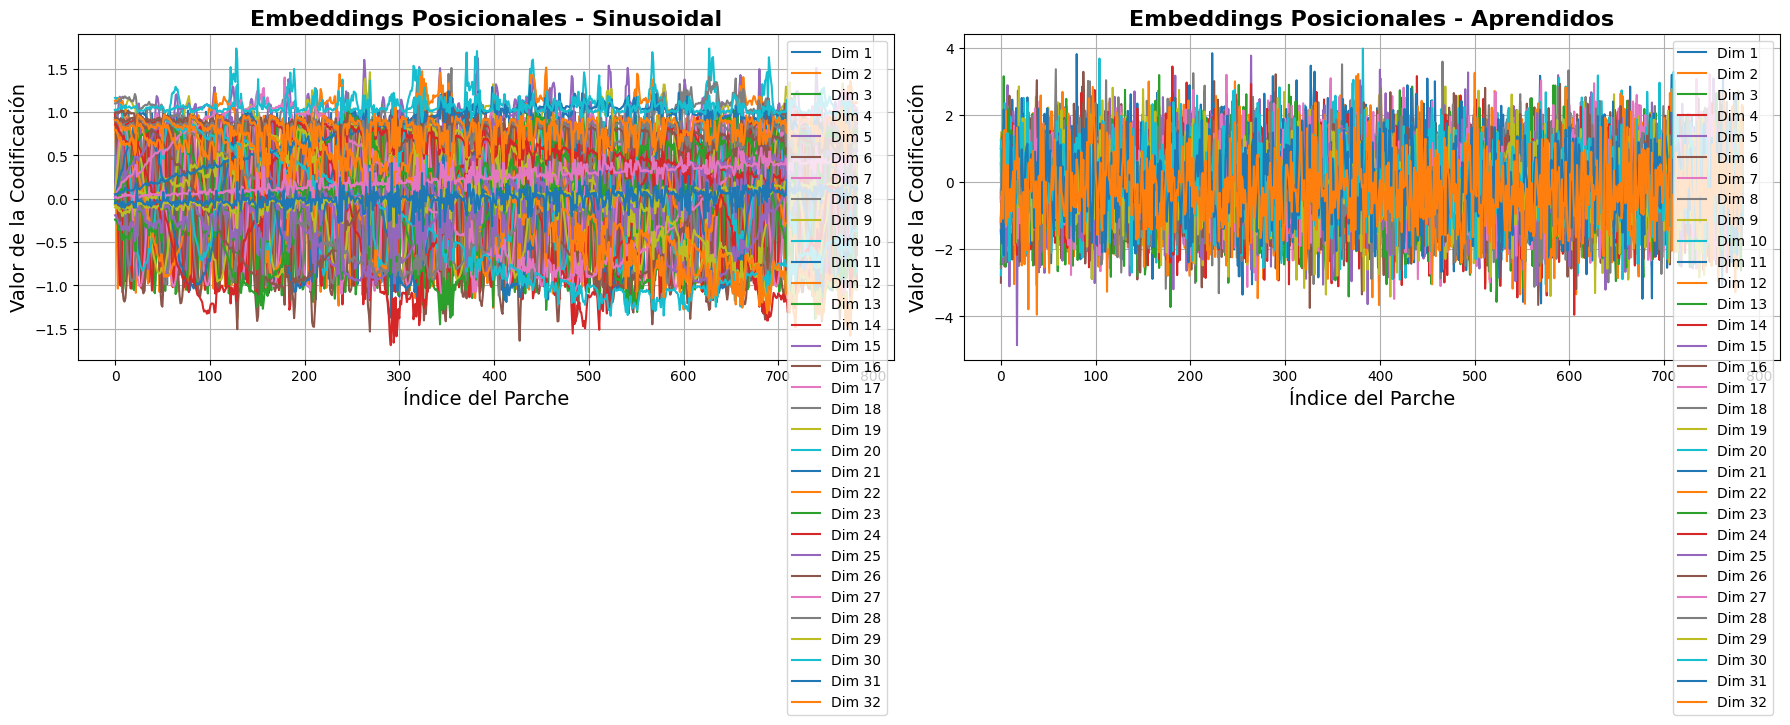

In [7]:

# Comparar codificaciones posicionales: Sinusoidal vs Aprendida
plt.figure(figsize=(18, 6))

# Sinusoidal
plt.subplot(1, 2, 1)
for i in range(embed_dim):
    plt.plot(pos_embeddings[0, :, i].detach().cpu().numpy(), label=f'Dim {i+1}')
plt.title('Embeddings Posicionales - Sinusoidal', fontsize=16, weight='bold')
plt.xlabel('Índice del Parche', fontsize=14)
plt.ylabel('Valor de la Codificación', fontsize=14)
plt.grid()
plt.legend()

# Aprendida
plt.subplot(1, 2, 2)
for i in range(embed_dim):
    plt.plot(pos_embeddings_learned[0, :, i].detach().cpu().numpy(), label=f'Dim {i+1}')
plt.title('Embeddings Posicionales - Aprendidos', fontsize=16, weight='bold')
plt.xlabel('Índice del Parche', fontsize=14)
plt.ylabel('Valor de la Codificación', fontsize=14)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


## Ventajas y desventajas de cambiar el tamaño de parches y dimensiones de embedding

* **Cantidad de Parches:**
  * **Aumentar:** Captura más detalles locales, mejor para texturas finas. Mayor costo computacional (más tokens).
  * **Disminuir:** Menor detalle espacial, pero más rápido de procesar.
* **Dimensión del Embedding:**
  *  **Aumentar:** Vectores más ricos, mayor capacidad de representación. Más parámetros, más memoria, riesgo de overfitting.
  * **Disminuir:** Vectores más simples, más rápidos y livianos. Puede perder capacidad de representar información compleja.


# **Conclusión:**
### En este trabajo se exploraron aspectos fundamentales de los Vision Transformers, analizando cómo afectan al modelo dos parámetros críticos: el tamaño de los parches y la dimensión de los embeddings.

### Se observó que disminuir el tamaño de los parches incrementa la cantidad de tokens a procesar, lo que mejora la capacidad de capturar detalles locales en las imágenes, pero también aumenta el costo computacional. De forma complementaria, aumentar la dimensión de los embeddings permite representar de manera más rica cada parche, aunque a costa de un mayor número de parámetros y posible riesgo de sobreajuste.

### La implementación de una codificación posicional aprendida mostró cómo los modelos pueden adaptarse dinámicamente a los datos, en contraste con la rigidez de la codificación sinusoidal. Esta flexibilidad puede ser especialmente beneficiosa en escenarios donde las relaciones espaciales en las imágenes no siguen patrones regulares.

### En resumen, el trabajo permitió comprender el delicado balance que debe lograrse entre capacidad de representación, eficiencia computacional y generalización al diseñar y entrenar arquitecturas basadas en Vision Transformers.